# GAN 0.3 балла

In [1]:
!pwd

/home/testing/pfedotova/hw1


In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
%matplotlib inline

/home/testing/pfedotova/cuda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!wget https://www.dropbox.com/s/329oy3cprlvn5vb/archive.zip


from zipfile import ZipFile

with ZipFile('archive.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-11-09 09:41:25--  https://www.dropbox.com/s/329oy3cprlvn5vb/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/329oy3cprlvn5vb/archive.zip [following]
--2022-11-09 09:41:26--  https://www.dropbox.com/s/raw/329oy3cprlvn5vb/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc726719a0787f1acecb1cb0f613.dl.dropboxusercontent.com/cd/0/inline/BwZrt0T0jEgUEi66cgyWMm6Thdxf-2JG6IhJ_lDr2FXLPslVXmc-0pUyl8KPHPQZnOi7XJGhnzAOqoNq1f7UIDCd4EzSsjfArk6g-k0m107tZuHp9vNInrnq5Rjt73or0dOK430VxCNWl2tjTK-xUeuEvNtfb_CP2AhNW0U0TYMfUA/file# [following]
--2022-11-09 09:41:26--  https://uc726719a0787f1acecb1cb0f613.dl.dropboxusercontent.com/cd/0/inline/BwZrt0T0jEgUEi66cgyWMm6Thdxf-2JG6IhJ_lDr2FXLPslVXmc-0pUyl8KPHPQZnOi7XJGhnzAOqoNq1f

In [3]:
calc_possible_combinations_for_deconv(64, 128)

possible comb: kernel=2 -- stride=2 -- padding=0
possible comb: kernel=4 -- stride=2 -- padding=1


In [2]:
# for the nicer images visualization 
# we make inverse transformation for normalization
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# functions to plot images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

# Utils functions for GPU usage of neural networks
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def calc_out_size_from_conv(input_size, kernel, stride, padding, dilation=1):
    return np.floor((((input_size + 2 * padding - dilation * (kernel - 1) - 1)/ stride) + 1))

def calc_possible_combinations_for_conv(input_size, output_size):
    for kernel in range(2, 5):
        for stride in range(1, 4):
            for padding in range(0, 4):
                if int(calc_out_size_from_conv(input_size, kernel, stride, padding)) == output_size:
                    print(f'possible comb: kernel={kernel} -- stride={stride} -- padding={padding}')

def calc_out_size_from_deconv(inp_size, kernel, stride, padding, dilation=1, out_padding=0):
    return (inp_size - 1) * stride - 2 * padding + dilation * (kernel - 1) + out_padding + 1

def calc_possible_combinations_for_deconv(input_size, output_size):
    for kernel in range(2, 5):
        for stride in range(1, 4):
            for padding in range(0, 4):
                if int(calc_out_size_from_deconv(input_size, kernel, stride, padding)) == output_size:
                    print(f'possible comb: kernel={kernel} -- stride={stride} -- padding={padding}')


def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    random_inds = np.random.randint(0, fake_images.shape[0], 64)
    random_sampled = fake_images[random_inds, : , :, :]
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    denormed = denorm(random_sampled)
    save_image(denormed, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denormed.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

In [45]:
DATA_DIR = './cats/'

# set parameters of the transformed data
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# As dataset is stored in the directory, we can create dataset
# as ImageFolder PyTorch object and set all the transformations here
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)]))

# Create PyTorch DataLoader object to produce batches
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

device = get_default_device()
show_batch(train_dl)
train_dl = DeviceDataLoader(train_dl, device)

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)


In [ ]:
# discriminato1 = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 64 x 32 x 32

#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ELU(0.1, inplace=True),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 256 x 12 x 12

#     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 10 x 10

#     nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(2048),
#     nn.ELU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
# discriminator2 = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False),
#     # out: 64 x 64 x 64
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
#     # out: 64 x 32 x 32

#     nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1, bias=False),
#     # out: 64 x 32 x 32
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
#     # out: 64 x 32 x 32

#     nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
#     # out: 128 x 16 x 16
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
#     # out: 128 x 16 x 16

#     nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
#     # out: 256 x 8 x 8
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
#     # out: 256 x 8 x 8

#     nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(1024, 1, kernel_size=3, stride=2, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
# discriminator = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False),
#     nn.LeakyReLU(0.01, inplace=True),
#     # out: 64 x 64 x 64

#     nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=2, padding=1, bias=False),
#     # out: 128 x 32 x 32
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.01, inplace=True),
#     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.01, inplace=True),
#     # out: 256 x 14 x 14

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=0, bias=False),
#     # out: 512 x 6 x 6
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.01, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
#     # out: 256 x 4 x 4

#     nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
# discriminator_base = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 32 x 32

#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
# generator1 = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 1024, kernel_size=2, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.ReLU(True),
#     # out: 1048 x 2 x 2

#     nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64

    
# )



In [ ]:
# generator2 = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 1024, kernel_size=2, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.ELU(0.1, inplace=True),
#     # out: 512 x 2 x 2

#     nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ELU(0.1, inplace=True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ELU(0.1, inplace=True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ELU(0.1, inplace=True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

latent_size = None

In [ ]:
# generator = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=2, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ELU(0.1, inplace=True),
#     # out: 512 x 2 x 2

#     nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ELU(0.1, inplace=True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ELU(0.1, inplace=True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ELU(0.1, inplace=True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

In [ ]:
# discriminator3 = nn.Sequential(
#     # in: 3 x 64 x 64

#     nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False),
#     nn.LeakyReLU(0.01, inplace=True),
#     # out: 64 x 64 x 64

#     nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=2, padding=1, bias=False),
#     # out: 128 x 32 x 32
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.01, inplace=True),
#     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.01, inplace=True),
#     # out: 256 x 14 x 14

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=0, bias=False),
#     # out: 512 x 6 x 6
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.01, inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
#     # out: 256 x 4 x 4

#     nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [ ]:
# generator3 = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ELU(0.1, inplace=True),
#     # out: 512 x 4 x 4

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ELU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     # nn.Upsample(scale_factor=2, mode='bilinear'),
#     # out: 256 x 6 x 6
#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ELU(0.1, inplace=True),
#     # out: 128 x 16 x 16

#     # nn.Upsample(scale_factor=2, mode='bilinear'),
#     # out: 128 x 16 x 16
#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ELU(0.1, inplace=True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

In [ ]:
# generator4 = nn.Sequential(
#     # in: latent_size x 1 x 1

#     nn.Linear(1, 512, bias=False),
#     nn.BatchNorm2d(256),
#     # out: 512 x 1

#     nn.ConvTranspose2d(512, 512, kernel_size=2, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 512 x 2 x 2

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 256 x 4 x 4

#     nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.1, inplace=True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 3 x 64 x 64
# )

In [2]:
# calc_possible_combinations_for_deconv(6, 8)

In [3]:
# fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# save_samples(0, fixed_latent)

In [9]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=True)
    
    return losses_g, losses_d, real_scores, fake_scores

In [4]:
# calc_possible_combinations_for_deconv(32, 64)

In [15]:
class Generator(nn.Module):
    def __init__(self, size_image, latent_dim):
        super(Generator, self).__init__()
        self.size_image = size_image
        self.latent_dim = latent_dim 

        self.init_size = self.size_image // 16   # == 4
        self.l1 = nn.Sequential(nn.Linear(1, self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(self.latent_dim),
            # init_size == 4
            # out: latent_dim x init_size x init_size
            
            nn.ConvTranspose2d(self.latent_dim, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            # out: 512 x 8 x 8

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            # out: 256 x 16 x 16

            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 16 x 16

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            # out: 128 x 32 x 32

            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, z):
        out = self.l1(z)
        # print(f'out shape: {out.shape}')
        out = out.view(batch_size, latent_size, self.init_size, self.init_size)
        # print(f'out shape: {out.shape}')
        img = self.conv_blocks(out)
        # print(f'img shape: {img.shape}')
        return img

In [52]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
    # out: 256 x 8 x 8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    # out: 256 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


discriminator = to_device(discriminator, device)

latent_size = 256

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

generator = Generator(size_image=image_size, latent_dim=latent_size)

generator = to_device(generator, device)

In [53]:
fixed_latent.shape

torch.Size([128, 256, 1, 1])

In [55]:
# save_samples(1, fixed_latent, show=True)

In [56]:
# xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors

# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [57]:
lr = 0.0001
epochs = 1

history = fit(epochs, lr, start_idx=1)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [3]:
a = [1, 2, 3]
b = [4, 5, 6]
a.extend(b)

In [4]:
a

[1, 2, 3, 4, 5, 6]

In [ ]:
id_number = 5


lr = 0.0001
epochs = 100
launches = 5
step_epoch = epochs // launches

for epoch in range(launches):
    history = fit(step_epoch, lr, start_idx=step_epoch * epoch)
    if epoch > 0:
        name = f'epochs_{step_epoch * epoch}-{step_epoch * (epoch + 1)}'
        path_full = '/content/drive/MyDrive/Sber/SberUni/CV/HW1/'
        g_filename = path_full + 'gen_' + name + f'__{id_number}.pth'
        d_filename = path_full + 'dis_' + name + f'__{id_number}.pth'
        
        torch.save(generator, g_filename)
        torch.save(discriminator, d_filename)
        print(f'weights saved for epoch: {step_epoch * (epoch + 1)}')

In [ ]:
# torch.save(generator, 'generator_weights.pth') 
# torch.save(discriminator, 'discriminator_weights.pth')

In [ ]:
# !ls /content/drive/MyDrive/Sber/SberUni/CV/HW1/
!cp -r /content/dis_epochs_0-0.pth /content/drive/MyDrive/Sber/SberUni/CV/HW1/
!cp -r /content/gen_epochs_0-0.pth /content/drive/MyDrive/Sber/SberUni/CV/HW1/

In [ ]:
!nvidia-smi

Tue Nov  8 13:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |   7378MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

Image('./generated/generated-images-0060.png')

vid_fname = f'/content/drive/MyDrive/Sber/SberUni/CV/HW1/gans_training_{id_number}.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

# !cp -r /content/gans_training_1.mp4 /content/drive/MyDrive/Sber/SberUni/CV/HW1/

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
plt.savefig(f'/content/drive/MyDrive/Sber/SberUni/CV/HW1/losses_{id_number}.png')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.savefig(f'/content/drive/MyDrive/Sber/SberUni/CV/HW1/scores_{id_number}.png')

## Улучшаем наш ГАН.

1. Попробуйте добавить большеConv-BN блоков в Дискриминатор
2. Попробуйте добавить Pooling в Дискриминатор
3. Попробуйте добавить больше Conv-BN блоков в Генератор
4. Увеличьте `latent_size`
5. Попробуйте использовать функцию активации ELU или LeakyReLU

Используйте, чтобы получить дополнительные подсказки [source](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)

## Генерируем лица!

1. Добавьте CenterCrop трансформацию к изображениями и уменьшите их размер
2. Используйте более глубокую GAN модель
3. Получите модель, которая выдает приемлимый аутпут с достаточно хорошими лицами (Хорошие - субъективный критерий, сделайте визуализацию и обоснуйте "хорошесть" модели)

In [ ]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz

# !tar xvzf tmp.tgz && rm tmp.tgz

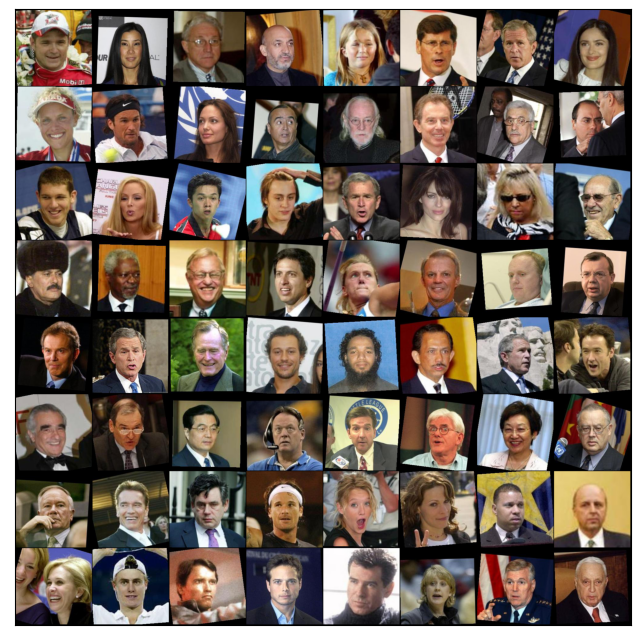

In [ ]:
DATA_DIR = './lfw-deepfunneled/'
image_size = 250
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

# Create PyTorch DataLoader object to produce batches
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

show_batch(train_dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
calc_output_size(input_size=31, kernel=4, stride=2, padding=1)

15.0

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 250 x 250

    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ELU(0.1, inplace=True),
    # out: 64 x 125 x 125

    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ELU(0.1, inplace=True),
    # out: 64 x 62 x 62

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ELU(0.1, inplace=True),
    # out: 128 x 31 x 31

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ELU(0.1, inplace=True),
    # out: 256 x 15 x 15

    nn.Linear(15 * 15 * 512, 2))

In [ ]:
discriminator = to_device(discriminator, device)

latent_size = 100

In [ ]:
calc_output_size_gen(2, kernel=4, stride=2, padding=1)

4

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.Linear(latent_size, 6 * 6 * 512),
    nn.BatchNorm2d(6 * 6 * 512),
    nn.ReLU(True),
    # out: 512 x 2 x 2

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ELU(0.1, inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ELU(0.1, inplace=True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ELU(0.1, inplace=True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ELU(0.1, inplace=True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)